In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.calibration import LabelEncoder
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

FOLDER_PATH = "../data_students/labeled_data/"
IMG_FEATURES = f"{FOLDER_PATH}img_features/"

%matplotlib widget

features_train = pd.read_csv(f'{FOLDER_PATH}X_train_combined.csv')
features_test = pd.read_csv(f'{FOLDER_PATH}X_test_combined.csv')
labels_train = pd.read_csv(f'{FOLDER_PATH}y_train.csv', header=None).squeeze()
labels_test = pd.read_csv(f'{FOLDER_PATH}y_test.csv', header=None).squeeze()

tabular_features = ['age', 'blood pressure', 'calcium', 'cholesterol', 'hemoglobin', 'height', 'potassium', 
                    'profession', 'sarsaparilla', 'smurfberry liquor', 'smurfin donuts', 'vitamin D', 'weight']
img_features = [col for col in features_train.columns if col not in tabular_features]

original_features_train = features_train[tabular_features].copy()
original_features_test = features_test[tabular_features].copy()

label_encoders = LabelEncoder()
features_train['profession'] = label_encoders.fit_transform(features_train['profession'])
features_test['profession'] = label_encoders.transform(features_test['profession'])

categorical_columns = features_train.select_dtypes(include=['object']).columns
satisfaction_order = ['Very low', 'Low', 'Moderate', 'High', 'Very high']
ordinal_encoders = OrdinalEncoder(categories=[satisfaction_order])
for column in categorical_columns:
    features_train[column] = ordinal_encoders.fit_transform(features_train[column].values.reshape(-1, 1))
    features_test[column] = ordinal_encoders.transform(features_test[column].values.reshape(-1, 1))

scaler = StandardScaler()
numerical_columns = features_train.select_dtypes(include=['float64', 'int64']).columns
features_train[numerical_columns] = scaler.fit_transform(features_train[numerical_columns])
features_test[numerical_columns] = scaler.transform(features_test[numerical_columns])

features = pd.concat([features_train, features_test])
features = features.fillna(features.mean())
labels = pd.concat([labels_train, labels_test])
original_features = pd.concat([original_features_train, original_features_test])
print(features.shape, labels.shape)

(1500, 525) (1500,)


In [ ]:
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans


tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features)

tsne_df = pd.DataFrame(features_tsne, columns=['Dimension 1', 'Dimension 2'])
tsne_df['Label'] = labels.values

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
tsne_df['Cluster'] = kmeans.fit_predict(features_tsne)

cluster_labels = {0: "high-risk", 2: "low-risk", 1: "medium-risk"}

most_relevant_items = {}
for cluster_id in range(n_clusters):
    cluster_indices = tsne_df[tsne_df['Cluster'] == cluster_id].index.tolist()
    cluster_labels_values = labels.iloc[cluster_indices]
    median_label = cluster_labels_values.median()
    closest_item_index = cluster_indices[(cluster_labels_values - median_label).abs().idxmin()]
    cluster_name = cluster_labels[cluster_id]
    most_relevant_items[cluster_name] = closest_item_index

for cluster_name, item_index in most_relevant_items.items():
    print(f"Cluster: {cluster_name}")
    print(f"Label Value: {labels.iloc[item_index]}")
    print(f"Smurf ID: {item_index}")
    print(f"Tabular Features Values:\n{original_features.iloc[item_index]}")
    print("-" * 50)

Cluster: high-risk
Label Value: 0.0
Smurf ID: 145
Tabular Features Values:
age                         20
blood pressure          104.31
calcium                   2.38
cholesterol              85.66
hemoglobin               14.03
height                    6.87
potassium                 4.05
profession            services
sarsaparilla         Very high
smurfberry liquor     Very low
smurfin donuts             Low
vitamin D                34.29
weight                  108.42
Name: 145, dtype: object
--------------------------------------------------
Cluster: medium-risk
Label Value: 0.14
Smurf ID: 39
Tabular Features Values:
age                        128
blood pressure          122.66
calcium                   2.61
cholesterol             102.61
hemoglobin               12.52
height                    7.33
potassium                  4.6
profession            services
sarsaparilla          Very low
smurfberry liquor         High
smurfin donuts       Very high
vitamin D                28.

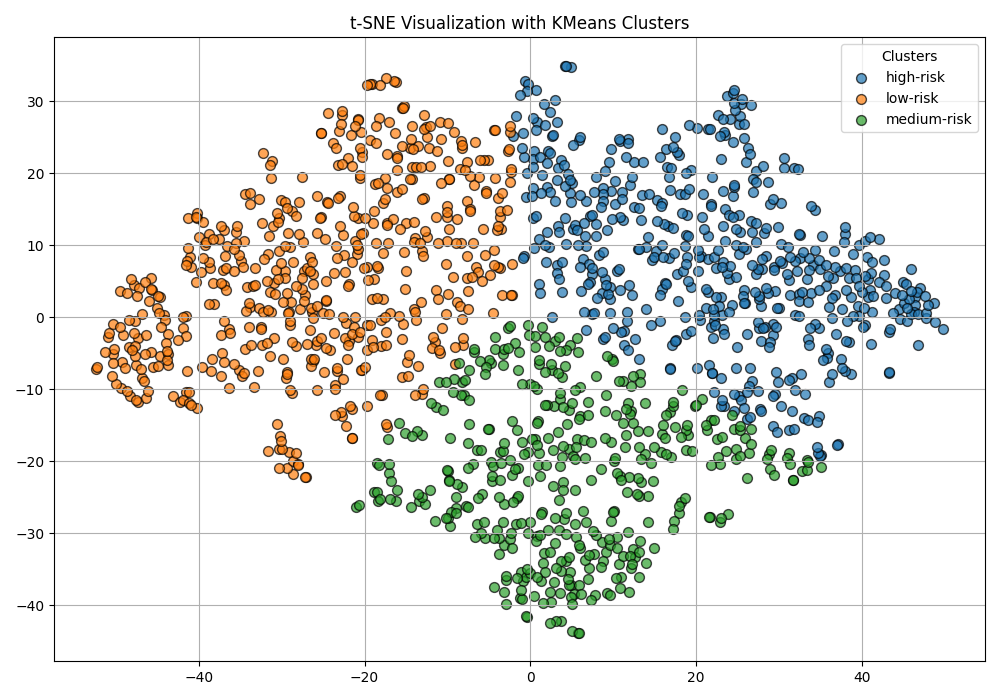

In [ ]:
plt.figure(figsize=(10, 7))
colors = plt.cm.tab10.colors
cluster_labels = {0: "high-risk", 2: "medium-risk", 1: "low-risk"}
for cluster_id in range(n_clusters):
    cluster_data = tsne_df[tsne_df['Cluster'] == cluster_id]
    plt.scatter(
        cluster_data['Dimension 1'],
        cluster_data['Dimension 2'],
        label=cluster_labels[cluster_id],
        color=colors[cluster_id],
        s=50,
        alpha=0.7,
        edgecolors='k'
    )

plt.legend(title="Clusters", loc="upper right")
plt.title('t-SNE Visualization with KMeans Clusters')
plt.grid(True)
plt.tight_layout()
plt.show()

##### Restriction of features (not mandatory)

In [12]:
def corr(X, y, n_features):
    X_copy = X.copy()
    X_copy['target'] = y
    corr = X_copy.corr(method='pearson')['target'].drop('target')
    abs_corr = corr.abs().sort_values(ascending=False)
    return abs_corr.iloc[:n_features].index.tolist()

tabular_features = ['age','blood pressure','calcium','cholesterol','hemoglobin','height','potassium','profession','sarsaparilla','smurfberry liquor','smurfin donuts','vitamin D','weight']
img_features = [col for col in features.columns if col not in tabular_features]

top_image_features = corr(features[img_features], labels, 21)
top_tabular_features = corr(features[tabular_features], labels, 9)

features = features[top_image_features + top_tabular_features]

In [2]:
def plot_2d_3d(features_reduced, labels, title, is_3d=False, labels_enabled=False):
    if is_3d:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')

        unique_labels = labels.unique()
        colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

        for label, color in zip(unique_labels, colors):
            indices = labels == label
            ax.scatter(
                features_reduced[indices, 0],
                features_reduced[indices, 1],
                features_reduced[indices, 2],
                label=f"Label {label}",
                c=[color],
                s=50
            )

        ax.set_title(f"{title} Visualization in 3D", fontsize=16)
        ax.set_xlabel(f"{title} Dimension 1", fontsize=12)
        ax.set_ylabel(f"{title} Dimension 2", fontsize=12)
        ax.set_zlabel(f"{title} Dimension 3", fontsize=12)
    else:
        plt.figure(figsize=(10, 7))
        unique_labels = labels.unique()
        colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

        for label, color in zip(unique_labels, colors):
            indices = labels == label
            plt.scatter(
                features_reduced[indices, 0],
                features_reduced[indices, 1],
                label=f"Label {label}",
                c=[color],
                s=50
            )

        plt.title(f"{title} Visualization in 2D", fontsize=16)
        plt.xlabel(f"{title} Dimension 1", fontsize=12)
        plt.ylabel(f"{title} Dimension 2", fontsize=12)

    if labels_enabled:
        plt.legend(
            title="Labels",
            loc="upper center",
            bbox_to_anchor=(0.5, -0.15) if is_3d else (0.5, -0.1),
            ncol=len(labels.unique()) // 3 + 1,
            frameon=False
        )
    plt.tight_layout()
    plt.show()

# UMAP

/var/folders/qx/vtjt5fs909n9h8xzf6qyft600000gn/T/ipykernel_15796/2881345093.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


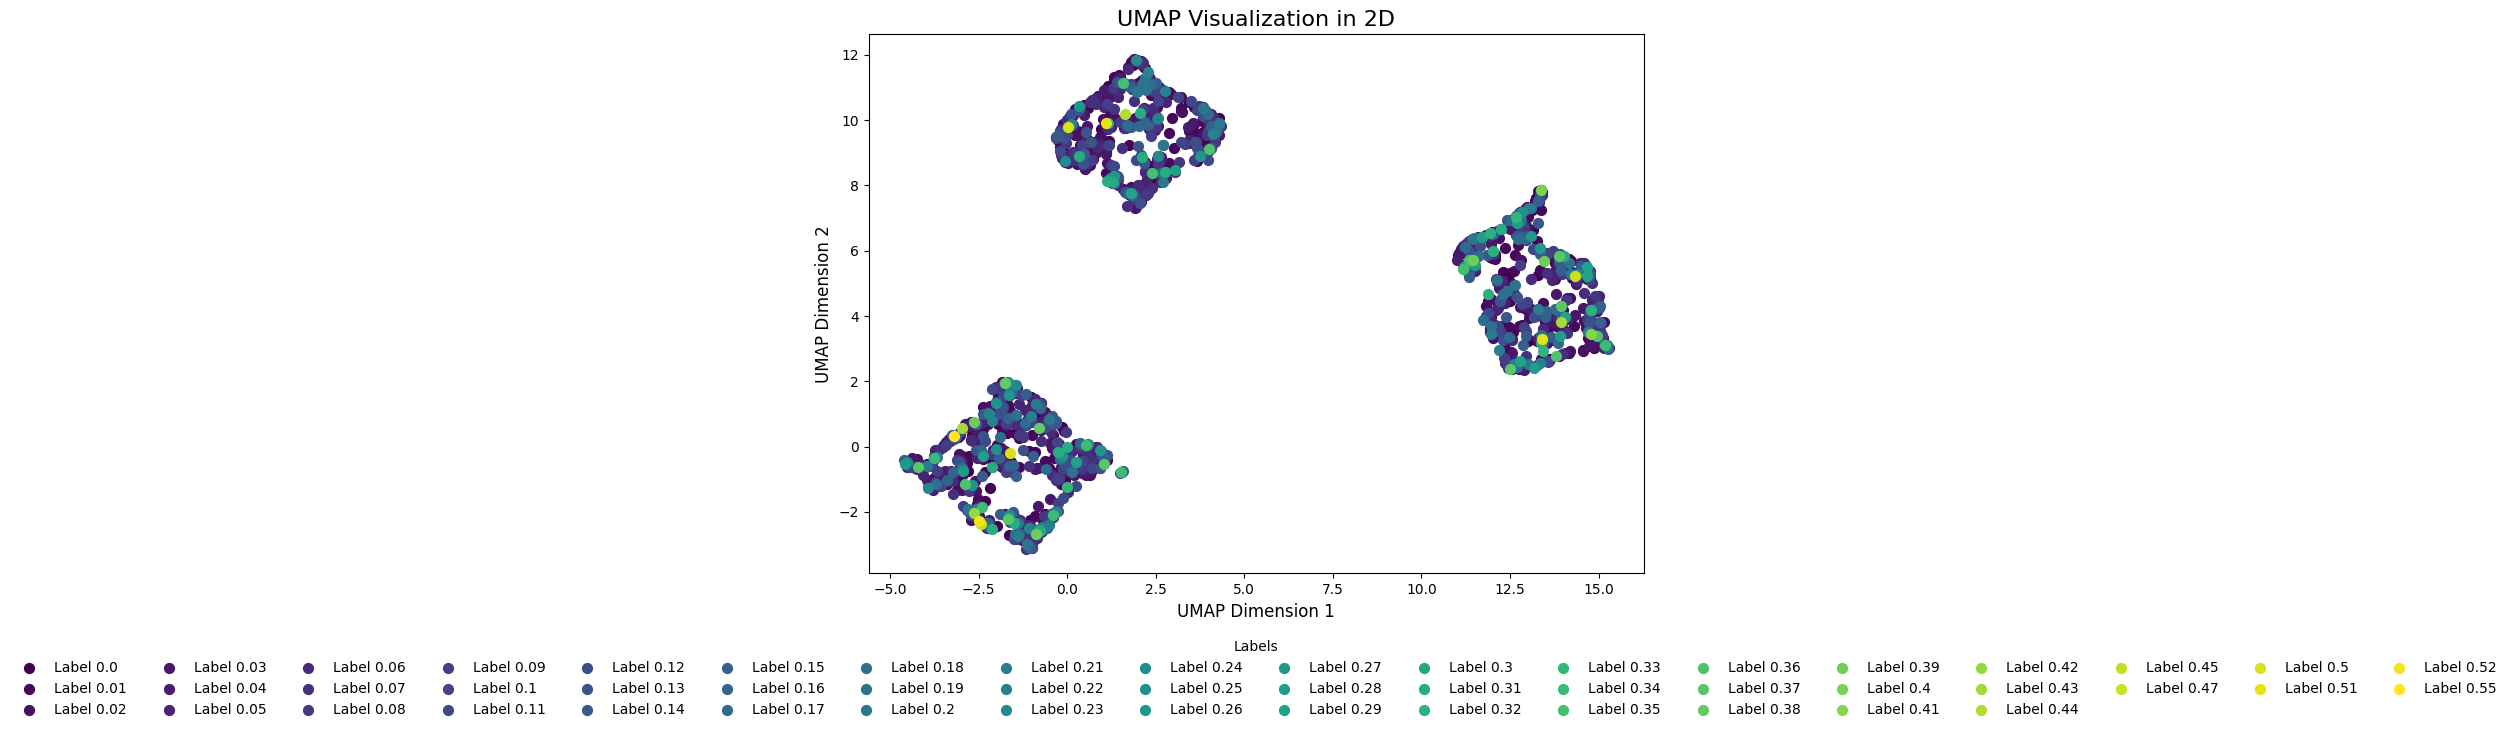

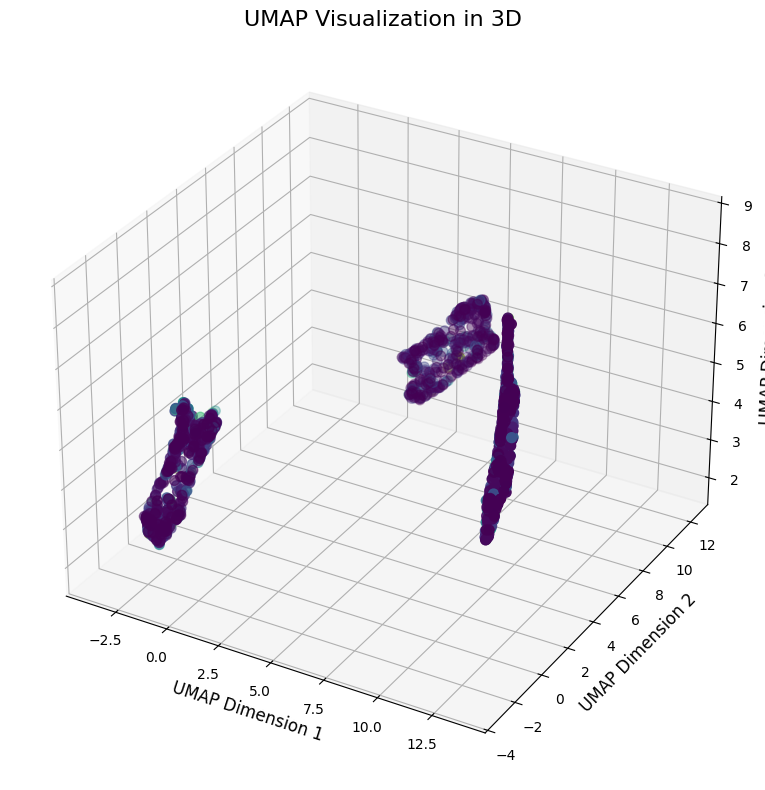

In [34]:
from umap.umap_ import UMAP

umap_2d = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42, n_jobs=1)
features_umap_2d = umap_2d.fit_transform(features)
plot_2d_3d(features_umap_2d, labels.sort_values(), title="UMAP", is_3d=False, labels_enabled=True)

umap_3d = UMAP(n_components=3, n_neighbors=15, min_dist=0.1, random_state=42, n_jobs=1)
features_umap_3d = umap_3d.fit_transform(features)
plot_2d_3d(features_umap_3d, labels.sort_values(), title="UMAP", is_3d=True)

# PCA

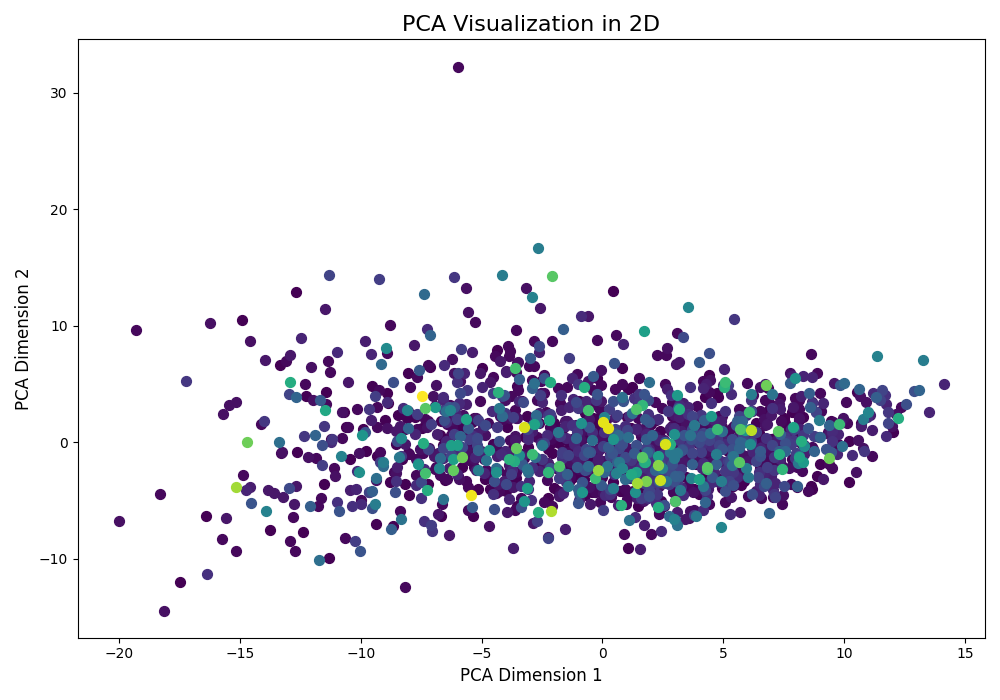

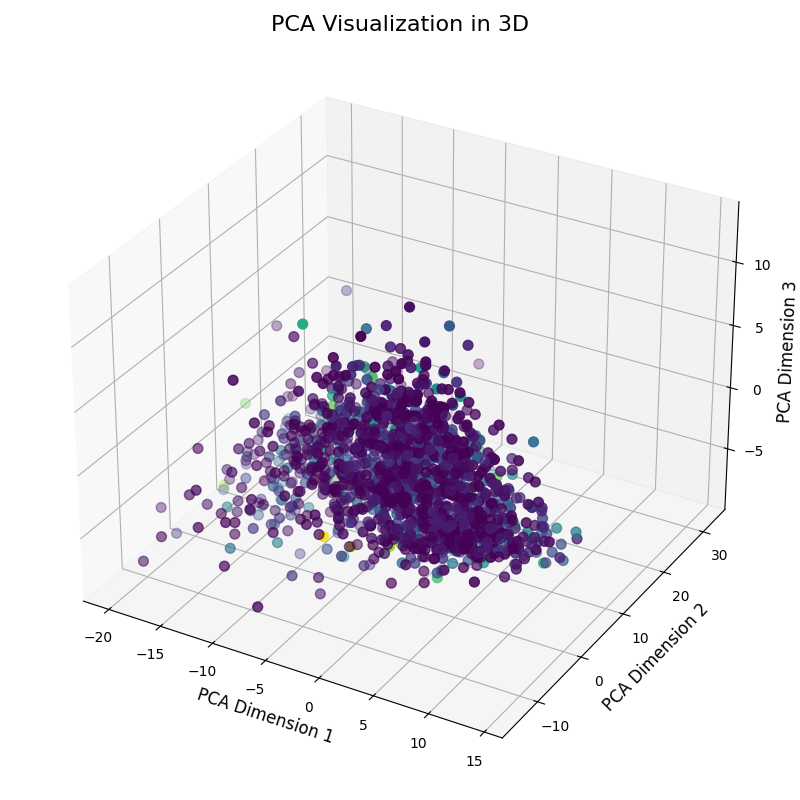

In [3]:
from sklearn.decomposition import PCA

pca_2d = PCA(n_components=4)
features_pca_2d = pca_2d.fit_transform(features)
plot_2d_3d(features_pca_2d, labels.sort_values(), title="PCA", is_3d=False)

pca_3d = PCA(n_components=4)
features_pca_3d = pca_3d.fit_transform(features)
plot_2d_3d(features_pca_3d, labels.sort_values(), title="PCA", is_3d=True)


# t-SNE

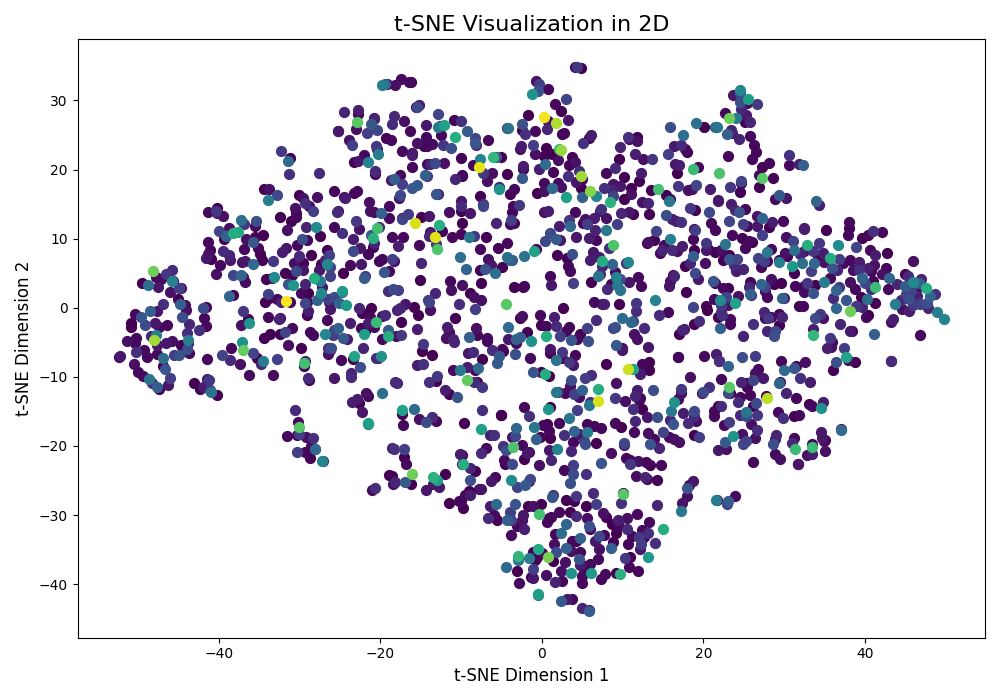

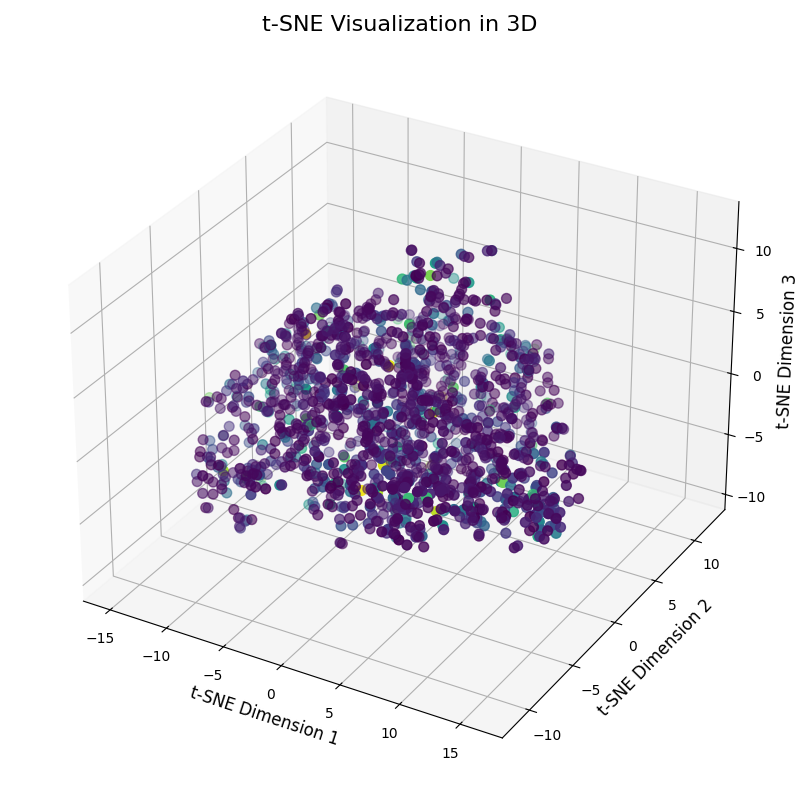

In [4]:
from sklearn.manifold import TSNE

tsne_2d = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
features_tsne_2d = tsne_2d.fit_transform(features)
plot_2d_3d(features_tsne_2d, labels.sort_values(), title="t-SNE", is_3d=False)

tsne_3d = TSNE(n_components=3, perplexity=30, random_state=42, max_iter=1000)
features_tsne_3d = tsne_3d.fit_transform(features)
plot_2d_3d(features_tsne_3d, labels.sort_values(), title="t-SNE", is_3d=True)


# Spectral Embedding

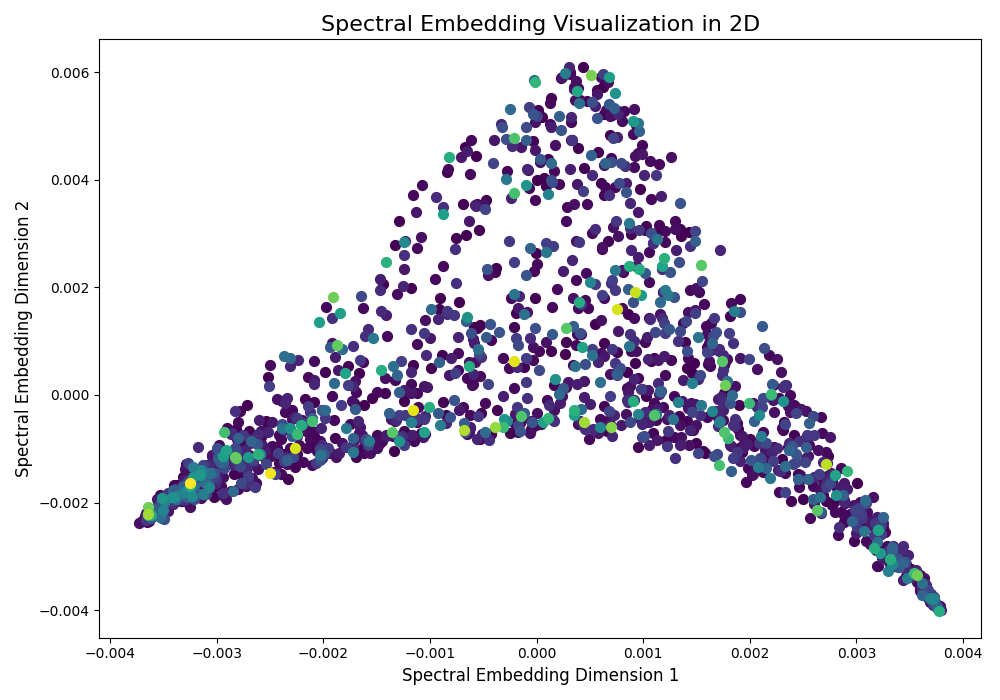

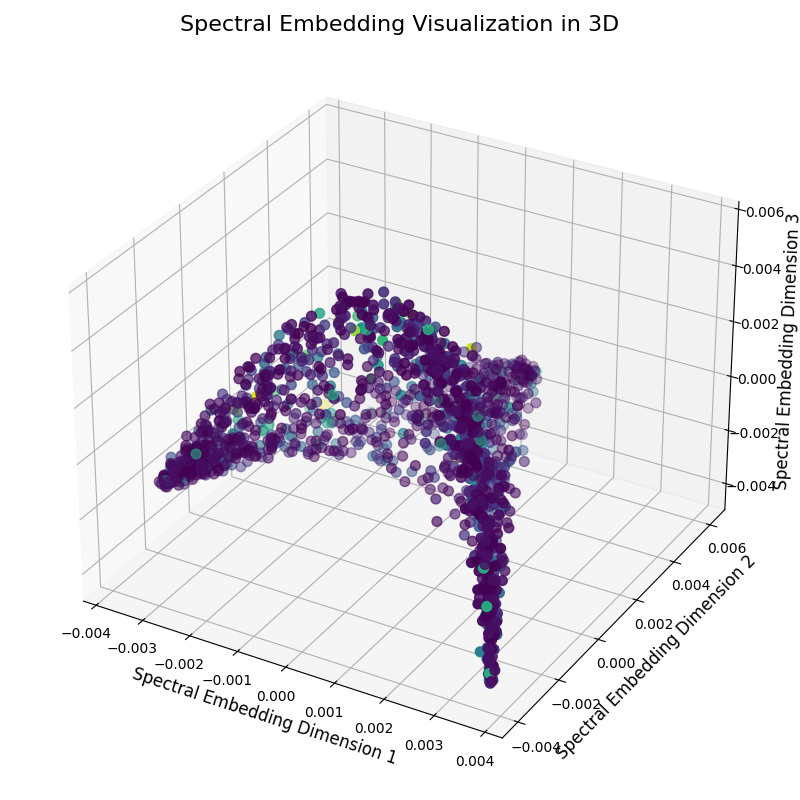

In [5]:
from sklearn.manifold import SpectralEmbedding

spectral_2d = SpectralEmbedding(n_components=2, affinity='nearest_neighbors', random_state=42)
features_spectral_2d = spectral_2d.fit_transform(features)
plot_2d_3d(features_spectral_2d, labels.sort_values(), title="Spectral Embedding", is_3d=False)

spectral_3d = SpectralEmbedding(n_components=3, affinity='nearest_neighbors', random_state=42)
features_spectral_3d = spectral_3d.fit_transform(features)
plot_2d_3d(features_spectral_3d, labels.sort_values(), title="Spectral Embedding", is_3d=True)


# Isomap

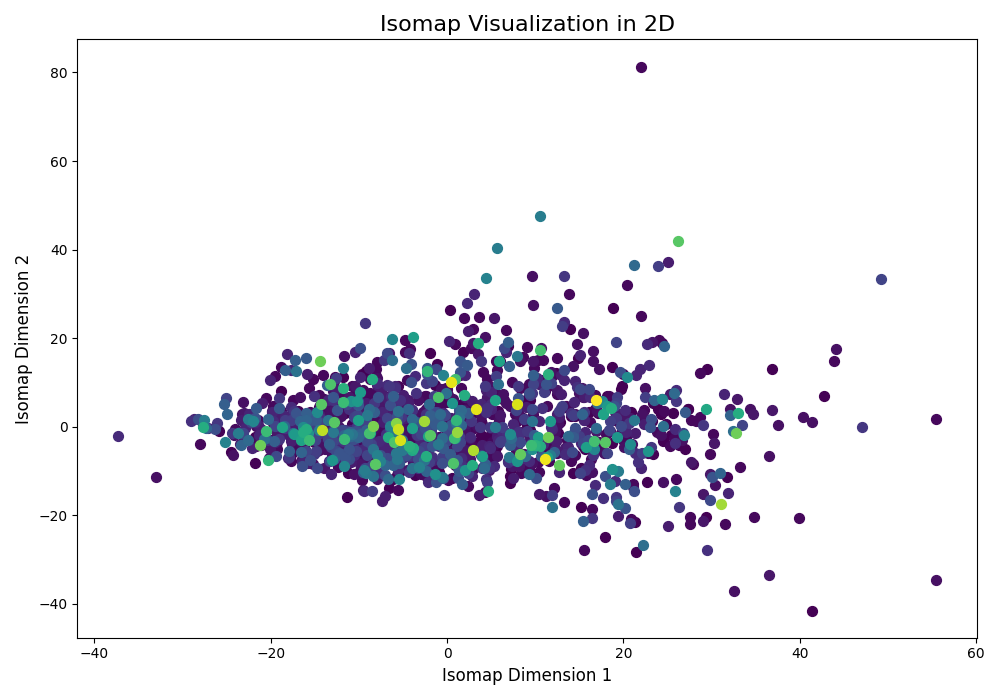

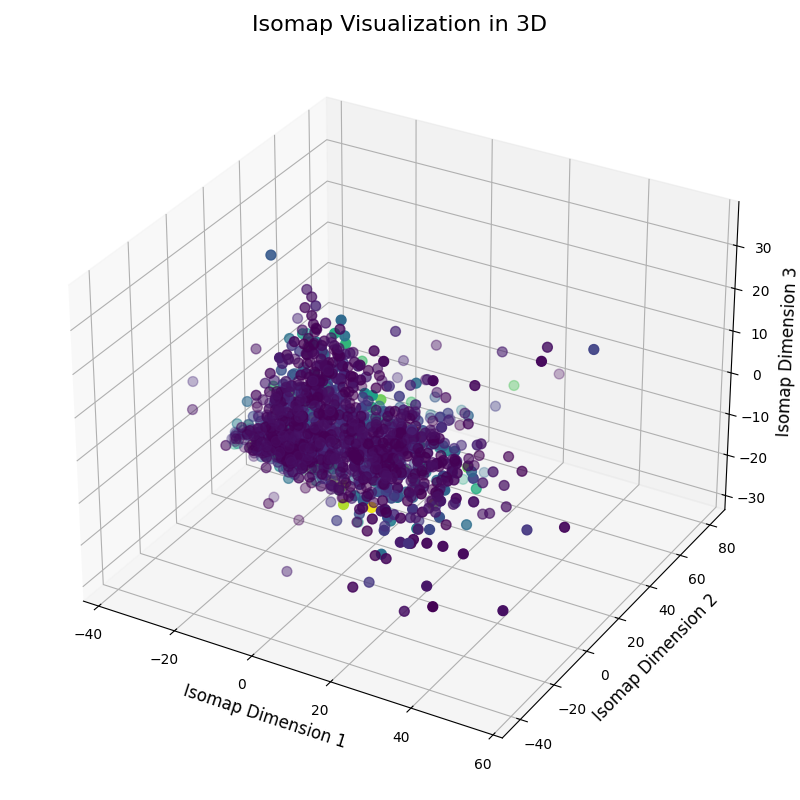

In [6]:
from sklearn.manifold import Isomap

isomap_2d = Isomap(n_components=2, n_neighbors=15)
features_isomap_2d = isomap_2d.fit_transform(features)
plot_2d_3d(features_isomap_2d, labels.sort_values(), title="Isomap", is_3d=False)

isomap_3d = Isomap(n_components=3, n_neighbors=15)
features_isomap_3d = isomap_3d.fit_transform(features)
plot_2d_3d(features_isomap_3d, labels.sort_values(), title="Isomap", is_3d=True)

# MDS

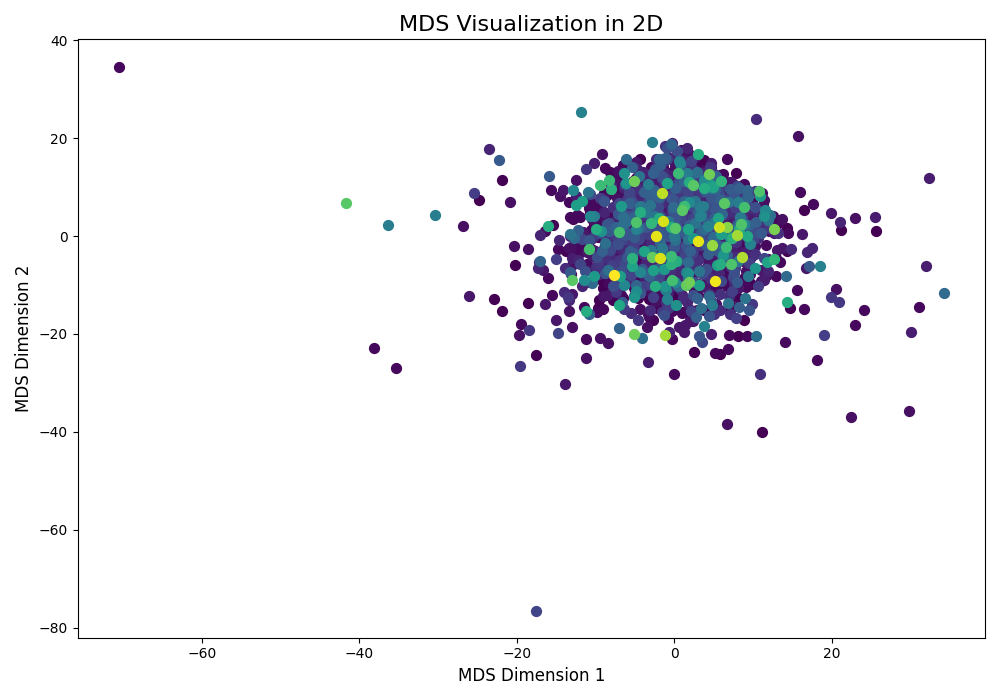

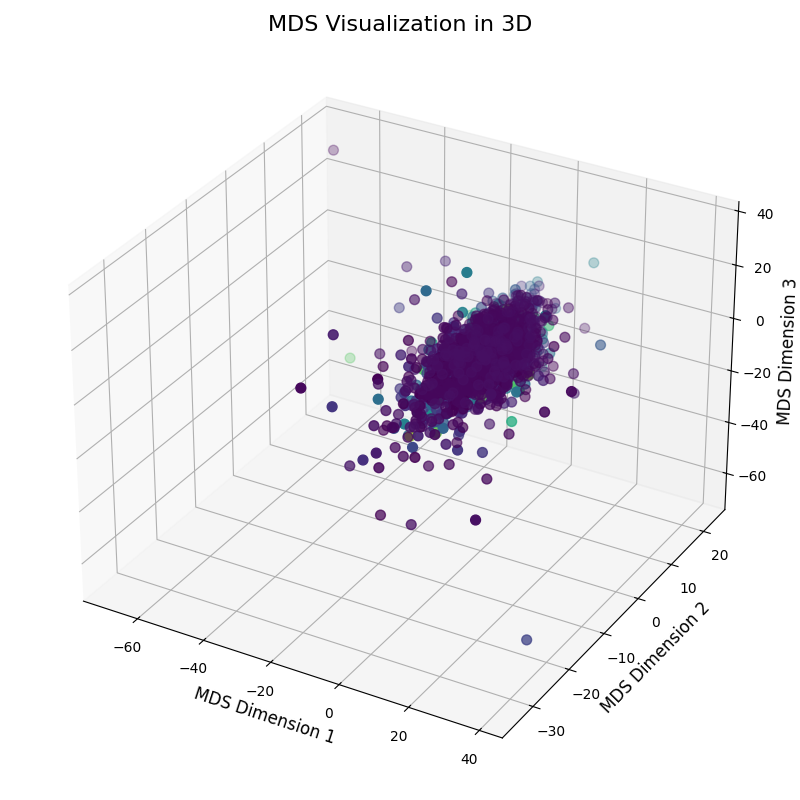

In [7]:
from sklearn.manifold import MDS

mds_2d = MDS(n_components=2, random_state=42)
features_mds_2d = mds_2d.fit_transform(features)
plot_2d_3d(features_mds_2d, labels.sort_values(), title="MDS", is_3d=False)

mds_3d = MDS(n_components=3, random_state=42)
features_mds_3d = mds_3d.fit_transform(features)
plot_2d_3d(features_mds_3d, labels.sort_values(), title="MDS", is_3d=True)